#### CIE4604 Simulation and Visualization

# Module 3 2.5D Visualization - Exercise 1 (Dutch Elevation Model)

**Hans van der Marel, 25 November 2021**

In this exercise you are going to explore several options to do 2.5D visualizations in Python. The data which we will be using is 100 meter resolution data from the *Actueel Hoogtebestand Nederland* (AHN-1), integrated with Bathemetric data, to cover the rivers, lakes and the Dutch coast. 

## Import the libraries

For the visualization we use `matplotlib.pyplot`. The Dutch elevation model with AHN and bathymetric data is provided as an NetCDF file. To read the NetCDF we need to import `netCDF4` module. We will be using `numpy` as well, so this is another import.

If the netCDF4 module is not installed, do `conda install netCDF4` from the command line first.

In [14]:
# Importing the libraries

import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc

plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (20, 20)


The elevation dataset is given in an NetCDF file with the name `mv100.nc`

The first thing to do is to find out the names of the variables used within this NetCDF file. To learn more about what is possible with the NetCDF module we could do a  `help(nc)` or `nc?`, but these command provide us with a bit too much information. You can find the documentation also here http://unidata.github.io/netcdf4-python , but much more useful is to have a look at the examples find here https://nbviewer.jupyter.org/github/Unidata/netcdf4-python/blob/master/examples/reading_netCDF.ipynb .

First, let read the netCDF dataset into a Python object, and print it:

In [15]:
# Read the data
grid = nc.Dataset('mv100.nc')
print('mv100',grid)

mv100 <class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    title: Digital Elevation Model of the Netherlands (maaiveld volgens Actueel Hoogtebestand Nederland, AHN) 100 m resolution
    institution: Actueel Hoogtebestand Nederland (AHN): Rijkswaterstaat + WaterSchapsHuis
    source: Geological Survey of the Netherlands
    history: $HeadURL: https://repos.deltares.nl/repos/OpenEarthRawData/trunk/tno/ahn100m/scripts/ahn2nc.m $ $Id: ahn2nc.m 4821 2011-02-01 14:24:22Z boer_g $
    references: http://www.ahn.nl/
    email: jan.stafleu@tno.nl
    comment: filtered version
    version:  
    Conventions: CF-1.4
    CF:featureType: Grid
    terms_for_use: These data can be used freely for research purposes provided that the following source is acknowledged: Actueel Hoogtebestand Nederland (AHN): Rijkswaterstaat + WaterSchapsHuis
    disclaimer: This data is made available in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even

This gives us already some useful information. What you see here are

- the global attributes,
- the dimensions, and
- the variable names

Which variable name contains the height information do you think (surprise...)? What are the other variables? Which type and dimensions do the variables have?

More information can be obtained using either one of the following commands. 
```Python
print('All dimensions', grid.dimensions)
print('All variables', grid.variable)
print('Depth', grid.variable['<variablename>'])
```
Try them out.

In [16]:
print(grid.variables)

OrderedDict([('x', <class 'netCDF4._netCDF4.Variable'>
int32 x(x)
    long_name: x-coordinate in Cartesian system
    units: m
    standard_name: projection_x_coordinate
    actual_range: [5.0000e+01 2.7995e+05]
    epsg: 28992.0
unlimited dimensions: 
current shape = (2800,)
filling on, default _FillValue of -2147483647 used), ('y', <class 'netCDF4._netCDF4.Variable'>
int32 y(y)
    long_name: y-coordinate in Cartesian system
    units: m
    standard_name: projection_y_coordinate
    actual_range: [300050. 624950.]
    epsg: 28992.0
unlimited dimensions: 
current shape = (3250,)
filling on, default _FillValue of -2147483647 used), ('longitude', <class 'netCDF4._netCDF4.Variable'>
float32 longitude(x, y)
    long_name: longitude
    units: degrees_east
    standard_name: longitude
    actual_range: [3.04720566 7.27442908]
    coordinates: latitude longitude
    grid_mapping: wgs84
unlimited dimensions: 
current shape = (2800, 3250)
filling on, default _FillValue of 9.969209968386869e+

Retrieve in this way the information for the 'depth' and 'epsg' variables...

What do these contain? Which map projection is used, and what does this tell us about the 'x' and 'y' coordinates? What is the *EPSG_code* of the projection and are the *proj4_parameters* used for?

In [17]:
print(grid.variables['depth'])
print('---')
print(grid.variables['epsg'])

<class 'netCDF4._netCDF4.Variable'>
float32 depth(x, y)
    long_name: hoogte t.o.v. NAP
    units: m
    _FillValue: nan
    actual_range: [-60.66 322.75]
    standard_name: height_above_reference_ellipsoid
    coordinates: latitude longitude
    grid_mapping: epsg
unlimited dimensions: 
current shape = (2800, 3250)
filling on
---
<class 'netCDF4._netCDF4.Variable'>
int32 epsg()
    name: Amersfoort / RD New
    epsg: 28992.0
    epsg_name: Oblique Stereographic
    grid_mapping_name:  
    semi_major_axis: 6377397.155
    semi_minor_axis: 6356078.962818189
    inverse_flattening: 299.1528128
    latitude_of_projection_origin: 52.0922178
    longitude_of_projection_origin: 5.23155
    false_easting: 155000.0
    false_northing: 463000.0
    scale_factor_at_projection_origin: 0.9999079
    proj4_params: +proj=sterea +lat_0=52.15616055555555 +lon_0=5.38763888888889 +k=0.999908 +x_0=155000 +y_0=463000 +ellps=bessel +units=m +towgs84=565.4174,50.3319,465.5542,-0.398957388243134,0.34398781

In [18]:
grid['epsg']

<class 'netCDF4._netCDF4.Variable'>
int32 epsg()
    name: Amersfoort / RD New
    epsg: 28992.0
    epsg_name: Oblique Stereographic
    grid_mapping_name:  
    semi_major_axis: 6377397.155
    semi_minor_axis: 6356078.962818189
    inverse_flattening: 299.1528128
    latitude_of_projection_origin: 52.0922178
    longitude_of_projection_origin: 5.23155
    false_easting: 155000.0
    false_northing: 463000.0
    scale_factor_at_projection_origin: 0.9999079
    proj4_params: +proj=sterea +lat_0=52.15616055555555 +lon_0=5.38763888888889 +k=0.999908 +x_0=155000 +y_0=463000 +ellps=bessel +units=m +towgs84=565.4174,50.3319,465.5542,-0.398957388243134,0.343987817378283,-1.87740163998045,4.0725 +no_defs
    EPSG_code: EPSG:28992
    projection_name: Dutch rijksdriekhoek system
    wkt: PROJCS["Amersfoort / RD New",
    GEOGCS["Amersfoort",
        DATUM["Amersfoort",
            SPHEROID["Bessel 1841",6377397.155,299.1528128,
                AUTHORITY["EPSG","7004"]],
            AUTHORITY[

What is the difference between the following command
```Python
z = grid.variables['depth']
z = grid.variables['depth'][:]
```
Find this out by printing the result.

Compute also the mean elevation for the dataset.

In [19]:
z = grid.variables['depth']
print('z',z)
print('z[:]',z[:])

z <class 'netCDF4._netCDF4.Variable'>
float32 depth(x, y)
    long_name: hoogte t.o.v. NAP
    units: m
    _FillValue: nan
    actual_range: [-60.66 322.75]
    standard_name: height_above_reference_ellipsoid
    coordinates: latitude longitude
    grid_mapping: epsg
unlimited dimensions: 
current shape = (2800, 3250)
filling on
z[:] [[-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 ...
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]]


In [20]:
z = grid.variables['depth'][:]
print('Mean elevation [m]',np.mean(z))

Mean elevation [m] 7.517602561659916


## Display height (depth) information using `imshow`

Display the height (depth) information using `imshow` from `matplotlib`. For this plot

- set the aspect ratio so that x- and y-increments are equal in size (axis equal),
- set the axis limits to the range of the data (axis tight),
- add a color bar with the appropriate label,
- use proper labels for the axis and title of the plot

Any surprises?

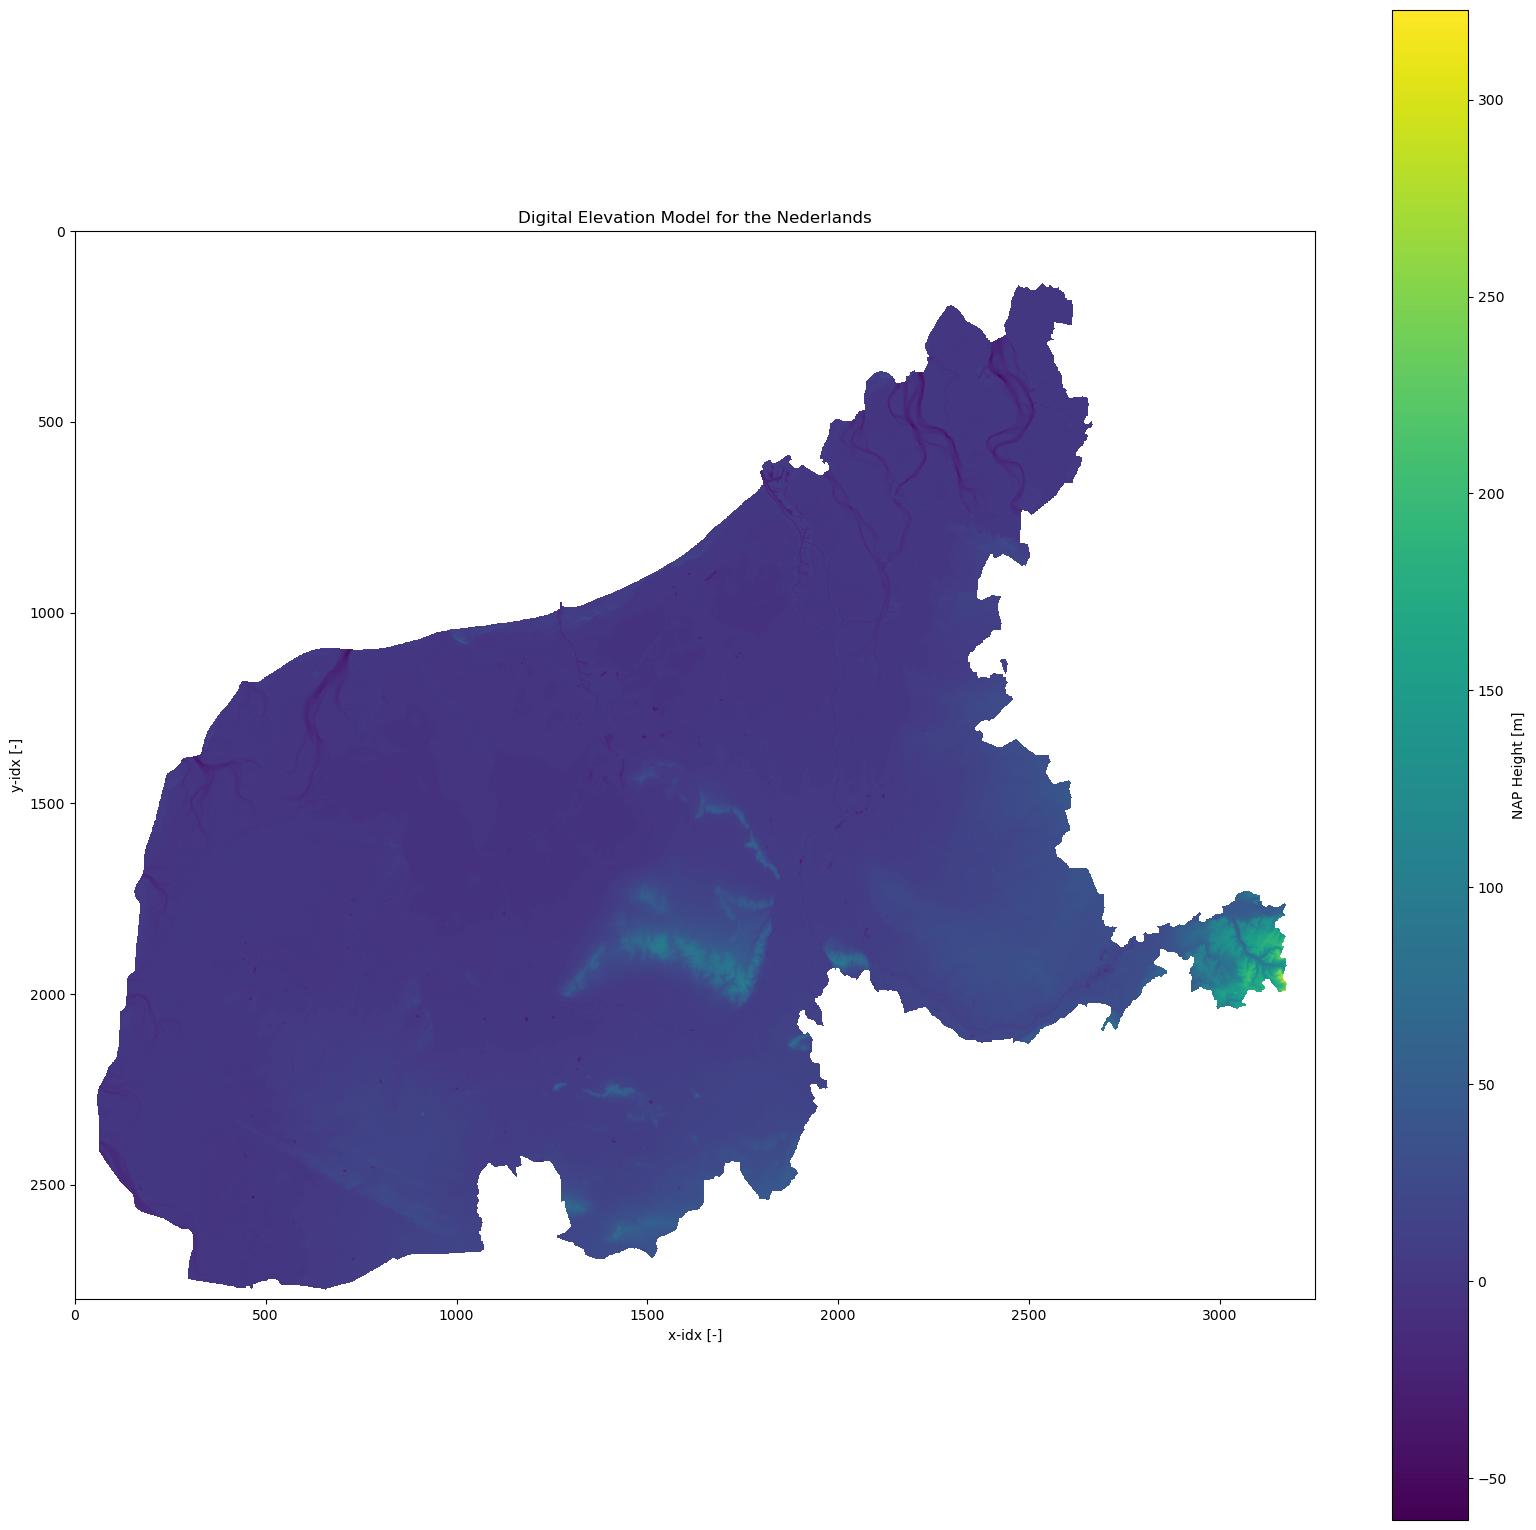

In [21]:
# Plot using imshow
plt.imshow(z)
plt.colorbar(label='NAP Height [m]')
ax.axis('equal')
ax.axis('tight')
plt.title('Digital Elevation Model for the Nederlands')
plt.xlabel('x-idx [-]')
plt.ylabel('y-idx [-]')
plt.show()

Impressed? Probably not... What can be done to improve?

- From the netCDF information we know depth is given as depth(x,y), so the the columns are running along the x-axis and row along the y-axis. Let try to transpose the matrix, that could help
- The colors are very flat. This is because the height/depth range is between -60 and + 330 m, though most of the values will be around the mean value. Try `plt.clim(zlow, zhigh)` to obtain a better presentation
- Try a different colormap, we come back to this
- The x- and y-coordinates are just indices to the depth matrix, not real X- and Y-coordinates, we have to change this

First things first, lets get the orientation right and experiment with `clim`. What would be good values for `clim` and what are the drawbacks of using `clim`?

Next try out some different colormaps. To set the colormap do something like this
```Python
cmap = plt.get_cmap('jet')
plt.imshow( ... , cmap=cmap)
```
For the available colormaps see https://matplotlib.org/tutorials/colors/colormaps.html . There's is a lot, but what would be a good colormap for the Netherlands? For now try out `jet` and `terrain`.

Don't spend too much time on it, it will be difficult to get it right with the standard colormaps. We will come back to this issue in more detail later.

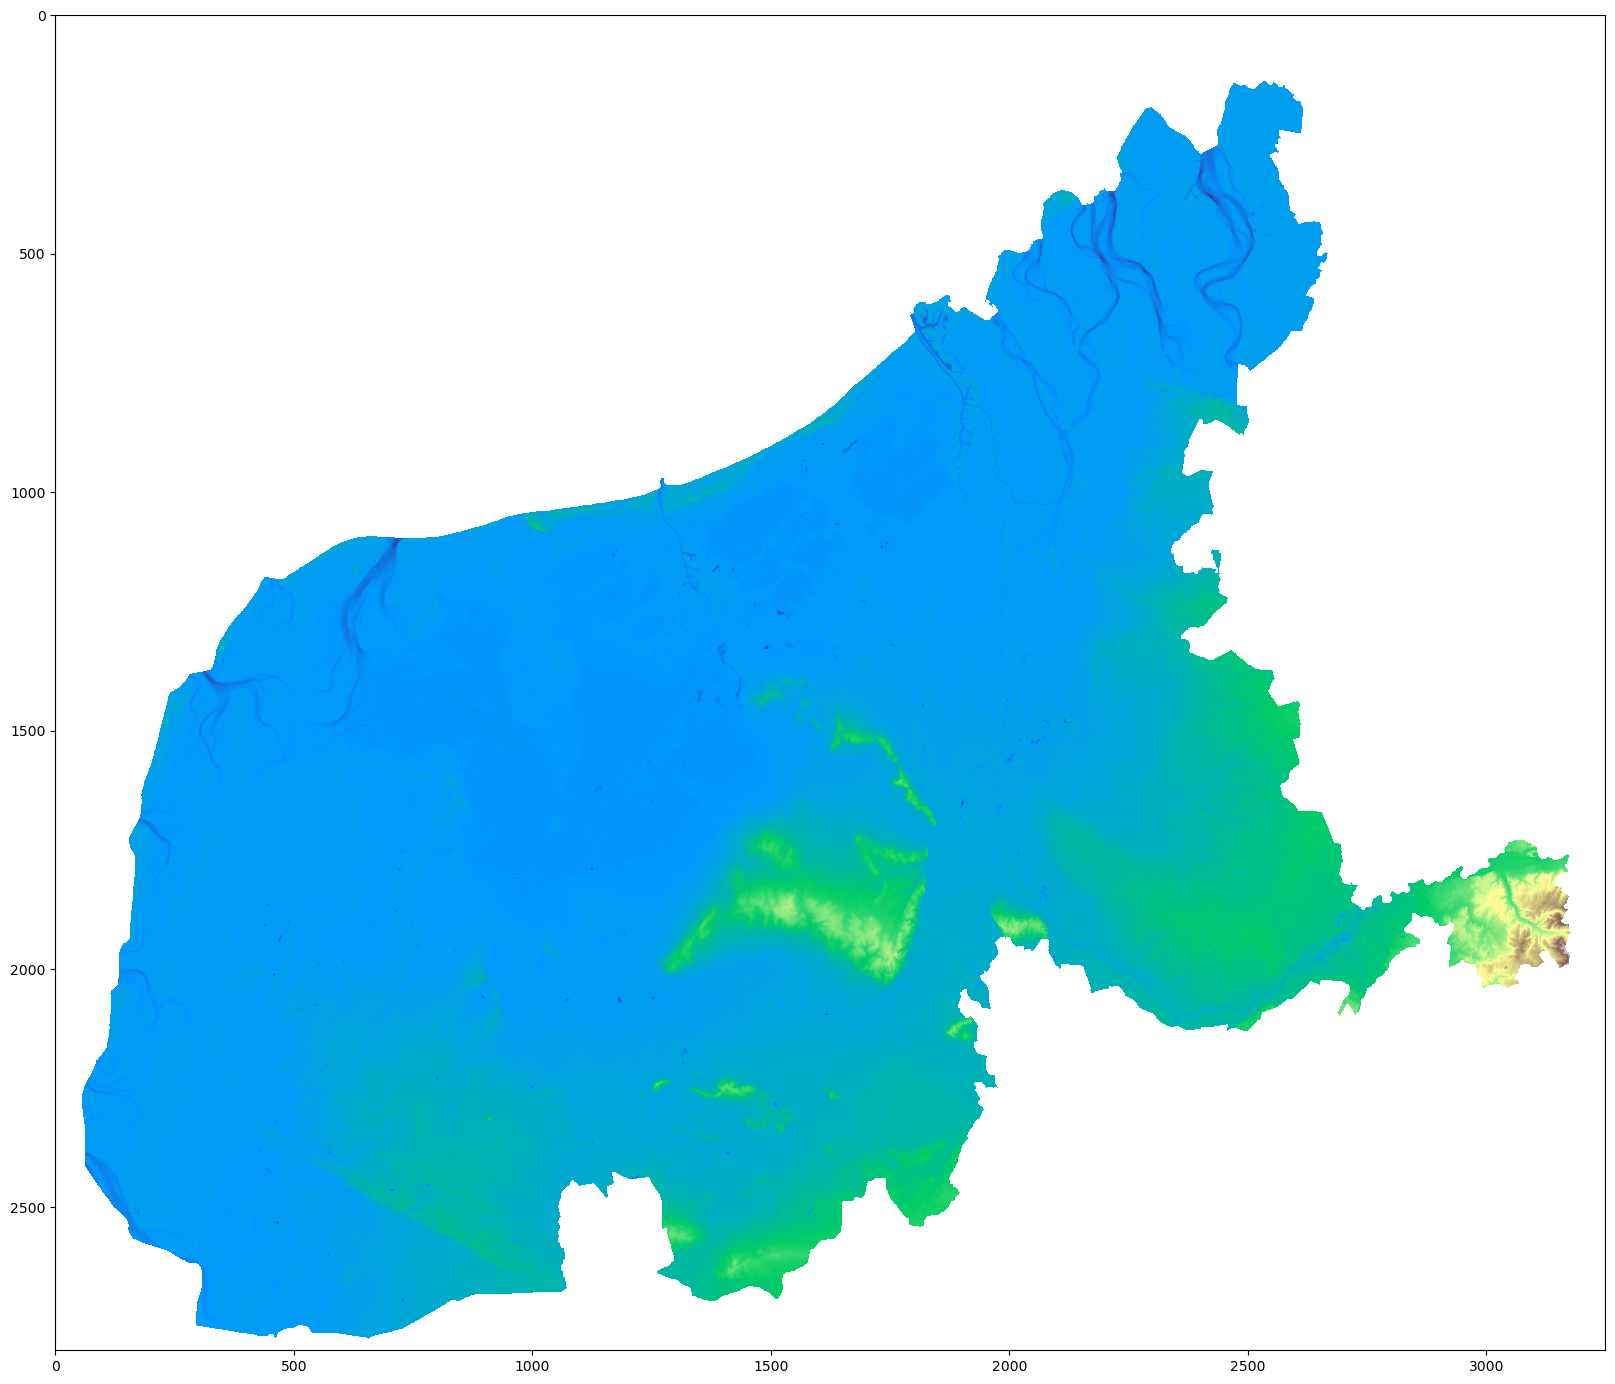

In [22]:
cmap = plt.get_cmap('terrain')
plt.imshow(z, cmap=cmap)

Before continuing with the colormaps, there is still the problem of the X- and Y-coordinates: `imshow` displays the index of the x- and y-axis. What we want is to see the RD-coordinates. We can use the `extent=[x_min, x_max, y_min, y_max]` of `imshow` to get the axis ticks right in `imshow`. This assumes we have regular grids, which use the same increments for the x- and/or y-axis.  

The example code is included below, note the use of `aspect='equal'` in `imshow` and the impact it has on the shape of the Netherlands.

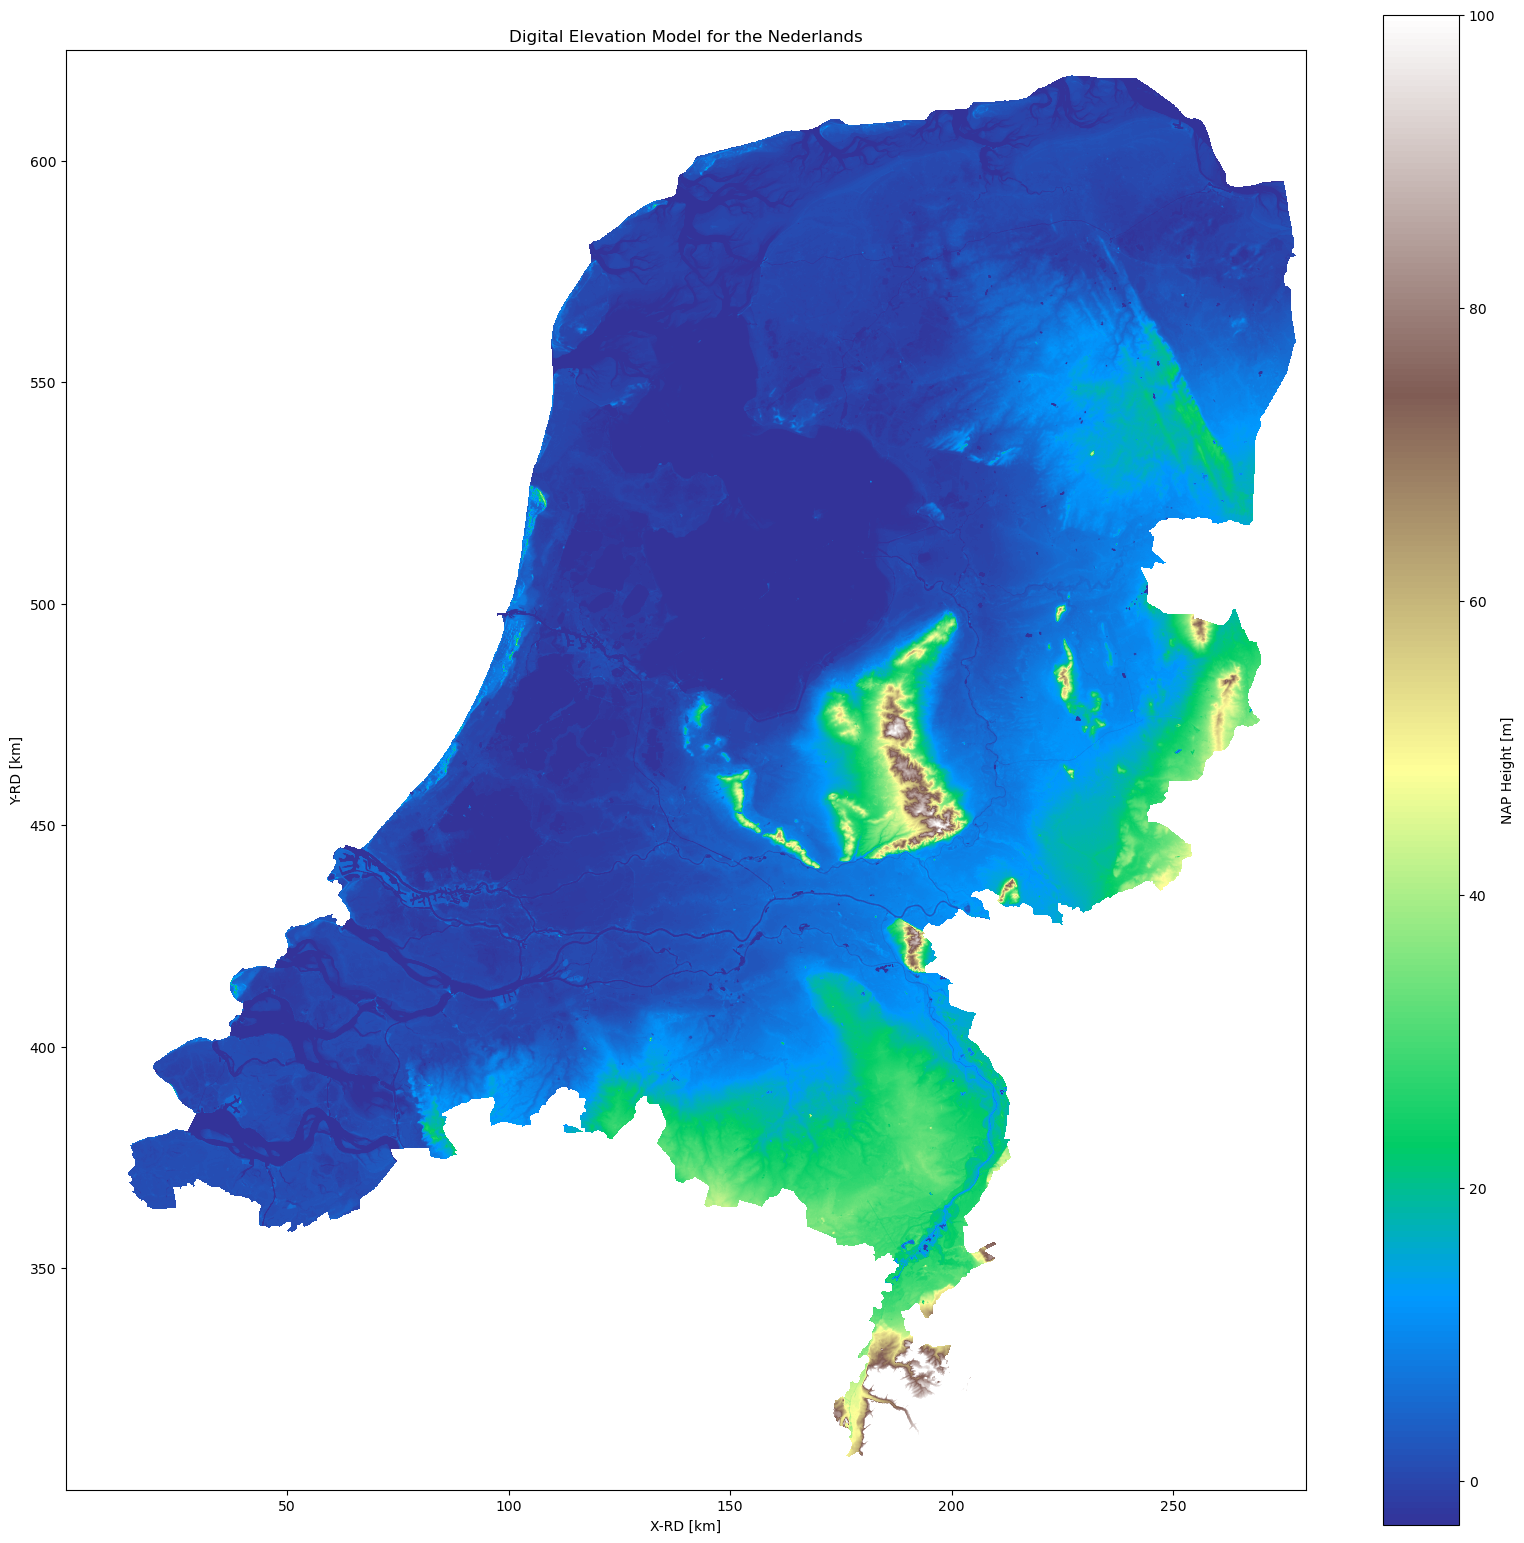

In [23]:
# Get the x, y and z data from the netCDF
x = grid.variables['x'][:]
y = grid.variables['y'][:]
z = grid.variables['depth'][:]

# Get the extend of the x- and y-range,so that we can set extent in imshow to display the correct x- and y-ticks
extent = [np.min(x)/1000 , np.max(x)/1000, np.min(y)/1000 , np.max(y)/1000]

# Plot using imshow
# fig, ax = plt.subplots(1, 1, figsize=(10, 8))
cmap = plt.get_cmap('terrain')
plt.imshow(z.T, cmap=cmap, aspect='equal', extent=extent)
plt.colorbar(label='NAP Height [m]')
plt.clim(-3,100)  
plt.title('Digital Elevation Model for the Nederlands')
plt.xlabel('X-RD [km]')
plt.ylabel('Y-RD [km]')
plt.show()

## Display height (depth) information using `pcolormesh`¶

In the previous section we used the `extent=[x_min, x_max, y_min, y_max]` of `imshow` to get the axis ticks right. This is only possible for regular grids which use the same increments for the x- and/or y-axis. When the increments are not the same you can use `pcolormesh` for creating a pseudo color plot instead of `imshow` (which is only for images).

`pcolormesh` has two additional inut arguments, the x- and y-coordinate. The column index of the matrix corresponds to the x-coordinate, and the row index corresponds to y, so we still have to transpose of flip the axis. 

If x and/or y are 1-D arrays or column vectors they will be expanded as needed into the appropriate 2-D arrays, making a rectangular grid.

For non-regular rectangular grids x and/or y are 2-D arrays.

Make the plot again, but now with the proper x- and y coordinates, using `pcolormesh`. Start by retrieving the x- and y-coordinates from the netCDF file. 

x (2800,)
y (3250,)
z (2800, 3250)


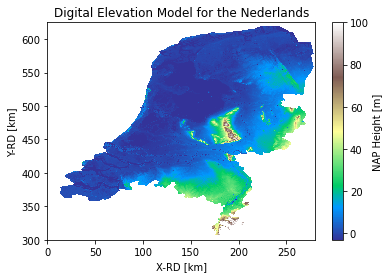

In [24]:
# Get the x, y and z data from the netCDF
x = grid.variables['x'][:]
y = grid.variables['y'][:]
z = grid.variables['depth'][:]

print('x',x.shape)
print('y',y.shape)
print('z',z.shape)

# Plot using matplotlib.pcolormesh
%matplotlib inline
#%matplotlib qt
# fig, ax = plt.subplots(1, 1, figsize=(10, 8))
cmap = plt.get_cmap('terrain')
plt.pcolormesh(x / 1000, y / 1000, z.T, cmap=cmap, shading='nearest')
plt.colorbar(label='NAP Height [m]')
plt.clim(-3, 100)
ax.axis('equal')
plt.title('Digital Elevation Model for the Nederlands')
plt.xlabel('X-RD [km]')
plt.ylabel('Y-RD [km]')
plt.show()

There is one new option that was used, `shading='nearest'`. This has to do how the coordinates are defined. If `shading='flat'`, the default, the coordinates are the corners of each mesh, 
```
(X[i+1, j], Y[i+1, j])       (X[i+1, j+1], Y[i+1, j+1])
                      +-----+
                      |     |
                      +-----+
    (X[i, j], Y[i, j])       (X[i, j+1], Y[i, j+1])
```
In this case the dimensions of X and Y should be one greater than those of the data. If X, Y and the data have equal dimensions a warning will be raised. If `shading='nearest'`, `shading='gouraud'` or `shading='auto'`, the dimensions of X and Y should be the same as those of the data. For 'nearest' the data[i,j] is centered on (X[i, j], Y[i, j]). For 'gouraud', a smooth interpolation is caried out between the quadrilateral corners.


Repeat the same plot, but now use Qt for the display instead of inline plot. You can do this by adding
```
%matplotlib qt
```
to the code. The main advantage of using Qt is that this allows you to interactivily change properties, including the colormap, zoom in/out, save, etc.

You can also do this by uncommenting the line in the previous code cell.

## Getting the colormap right ...

Matplotlib (and Matlab) objects that use colormaps by default linearly map the colors in the colormap from data values *vmin* to *vmax*. This mapping is done in two steps,

- a normalization from the input data to \[0, 1\] first,
- then mapping onto the indices in the colormap.

Normalizations are actually classes defined in the `matplotlib.colors()` module. The default, linear normalization is `matplotlib.colors.Normalize()`. See also https://matplotlib.org/3.3.3/api/colors_api.html .

To get the colormap right we need to know how the heights/depths are distributed, so that these can be sensibly *distributed* over the interval \[0,1\], and then mapped to colors using the colormap.

For starters, we are going to make an histogram of the height/depth data

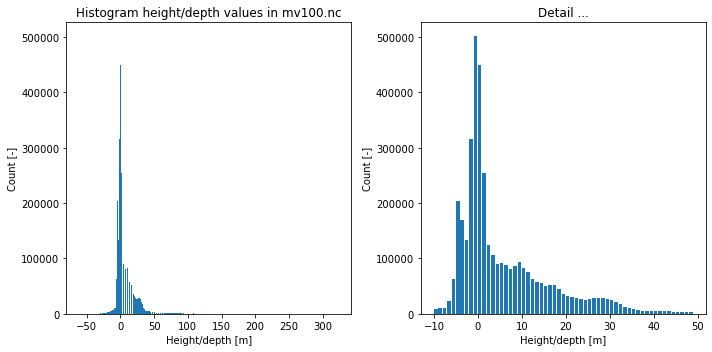

In [29]:
# histogram of the data
hist, bin_edges = np.histogram(z[:], np.arange(-61,324,1), range=(-61, 334), density=False)

# plot the histogram
plt.figure(figsize=(10,5), tight_layout=True)
plt.subplot(1, 2, 1)
plt.bar(bin_edges[0:-1], hist, align='edge')
plt.xlabel('Height/depth [m]')
plt.ylabel('Count [-]')
plt.title('Histogram height/depth values in mv100.nc')

# histogram of the data
hist, bin_edges = np.histogram(z[:], np.arange(-10,50,1), range=(-61, 334), density=False)

# plot the histogram
plt.subplot(1, 2, 2)
plt.bar(bin_edges[0:-1], hist, align='edge')
plt.xlabel('Height/depth [m]')
plt.ylabel('Count [-]')
plt.title('Detail ...')

plt.show()

It makes sense to use more colors for heights with occur more often, and less for height that are less frequent.

There are two ways to do this

1. Make a new colormap
2. Use a differnt normalization

#### Make your own colormap

One way to do this is by making our own colormap.  In the past I made a color map in Matlab that better fits the data. Let's load this map.

We need to import `loadmat` from `scipy` and `matplotlib.colors` for the colormap support.

The colormap is read from a matlab mat file, it has three columns, with respectively the RGB values, and 256 values (different colors). The map is converted to a Python colormap using `ListedColormap`. We also plot the RGB values to see what is in the map.

See https://matplotlib.org/3.3.3/tutorials/colors/colormap-manipulation.html for all available option of creating your own colormaps.

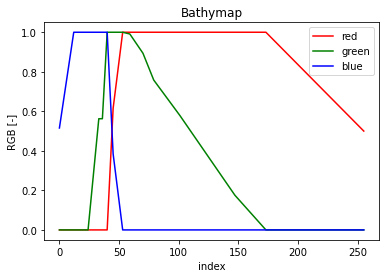

In [26]:
# Using scipy to load mat file
from scipy.io import loadmat
from matplotlib.colors import ListedColormap

bathymap = loadmat('bathymap.mat')
bathymap = bathymap['bathymap']
cmapBathy = ListedColormap(bathymap)

plt.figure()
plt.plot(bathymap[:,0], color='r', label='red')
plt.plot(bathymap[:,1], color='g', label='green')
plt.plot(bathymap[:,2], color='b', label='blue')
plt.xlabel('index')
plt.ylabel('RGB [-]')
plt.title('Bathymap')
plt.legend()
plt.show()


Below is the result of my Matlab brew map. I'm sure you can do better than this!! 

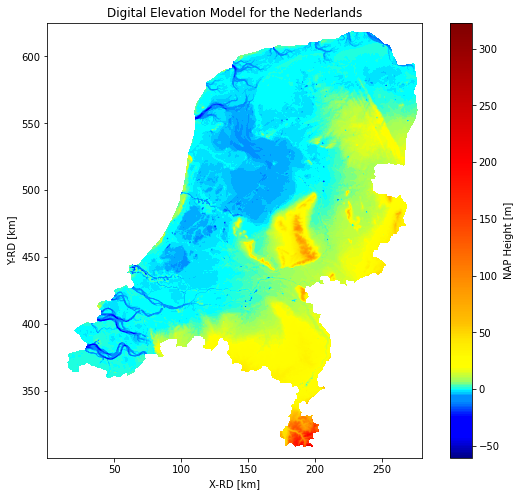

In [27]:
x = grid.variables['x'][:]
y = grid.variables['y'][:]
z = grid.variables['depth'][:]

# Get the extend of the x- and y-range,so that we can set extent in imshow to display the correct x- and y-ticks
extent = [np.min(x)/1000 , np.max(x)/1000, np.min(y)/1000 , np.max(y)/1000]

# Plot using matplotlib.imshow (or pcolormesh)
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
#plt.pcolormesh(x / 1000, y / 1000, z.T, cmap=cmapBathy, shading='nearest')
plt.imshow(z.T, cmap=cmapBathy, aspect='equal', extent=extent)
plt.colorbar(label='NAP Height [m]')
plt.title('Digital Elevation Model for the Nederlands')
plt.xlabel('X-RD [km]')
plt.ylabel('Y-RD [km]')
plt.show()

#### Use a different normalization

Matplotlib (and Matlab) objects that use colormaps by default linearly map the colors in the colormap from data values vmin to vmax. Several alternatives are discussed in the documentation at https://matplotlib.org/3.3.3/tutorials/colors/colormapnorms.html .


The Normalize instance scales the data values to the canonical colormap range [0, 1] for mapping to colors. By default, the data range is mapped to the colorbar range using linear scaling. Alternatives are logarithmic scaling, a powerlaw or discrete bounds. 

**It is left as an exercise to try this our yourself.**

Do this, you will need to get some practice for the assignment when you need to find a good colormap for the NDVI.

In [28]:
# Try out the normilization options yourself

There are also some hints in the next exercise.

[End of this notebook]